# Analysis for figure S7

## imports & installations

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import itertools
import os
from scipy.stats import normaltest
from itertools import groupby
import datetime

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import analysis.calc_single_cell_properties as calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
from configuration import consts

## data loading - differentiation scores dataframes

In [2]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [3]:
scores_df_s3 = calculator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.vid_info_dict["3"]['actin_path'])
scores_df_s2 = calculator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.vid_info_dict["2"]['actin_path'])
scores_df_s5 = calculator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.vid_info_dict["5"]['actin_path'])
scores_df_s1 = calculator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.vid_info_dict["1"]['actin_path'])

In [4]:
scores_df_s3["target"] = 1
scores_df_s2["target"] = 0
scores_df_s5["target"] = 1
scores_df_s1["target"] = 0

scores_df_s3_s2 = pd.concat([scores_df_s3, scores_df_s2])
scores_df_s5_s1 = pd.concat([scores_df_s5, scores_df_s1])

print("#cells s3: ", scores_df_s3["Spot track ID"].nunique(), "#cells s2: ", scores_df_s2["Spot track ID"].nunique())
print("#cells s5: ", scores_df_s5["Spot track ID"].nunique(), "#cells s1: ", scores_df_s1["Spot track ID"].nunique())

#cells s3:  675 #cells s2:  95
#cells s5:  420 #cells s1:  249


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


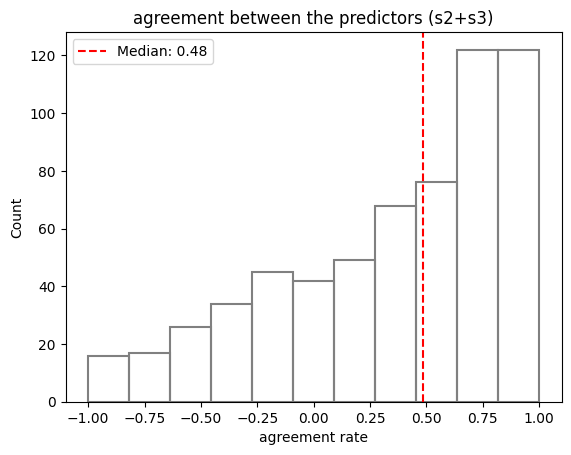

number of cells in the analysis:  692


<Figure size 640x480 with 0 Axes>

In [5]:
def plot_corr_histplot(corr, title, xlabel, color="gray"):
    median = np.nanmedian(corr)
    sns.histplot(corr, fill=False, color=color)    
    plt.axvline(median, color='r', linestyle='dashed', label='Median: {:.2f}'.format(median))

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.savefig(consts.storage_path + f"eps_figs/agreement of both predictors (s2 + s3).eps", format="eps")
    plt.show()
    plt.clf()
    print("number of cells in the analysis: ", len(corr)) 
    return median
    

corr = utils.get_correlation_coefficients(scores_df_s3_s2, (6,13), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
median_corr_s3_s2 = plot_corr_histplot(corr, "agreement between the predictors (s2+s3)", "agreement rate", color="gray")

In [6]:
def get_cells_by_correlation_rate(data, corr_range, x_property, y_property, rolling_w=1, time=(0,25), corr_metric="pearson"):
    data_copy = data.copy()
    data_copy = data_copy[(data_copy["time"]>=time[0]) & (data_copy["time"]<=time[1])]
    data_copy[x_property] = data_copy[x_property].rolling(rolling_w).mean()
    data_copy[y_property] = data_copy[y_property].rolling(rolling_w).mean()
    corr = data_copy.astype('float64').groupby('Spot track ID')[[x_property, y_property]].corr(method=corr_metric).iloc[0::2][[y_property]]
    condition = (corr[y_property] >= corr_range[0]) & (corr[y_property] <= corr_range[1])

    cell_ids_above_thresh = corr[condition][y_property].reset_index()['Spot track ID']
    
    return data[data["Spot track ID"].isin(cell_ids_above_thresh)]

we will now explore the cells acording to the level of consent between the two models, and will divide the cells into groups by the consents level:
1. correlation is in range (-1, -0.5)
2. correlation is in range (-0.5, 0)
3. correlation is in range (0, 0.5)
4. correlation is in range (0.5, 1)



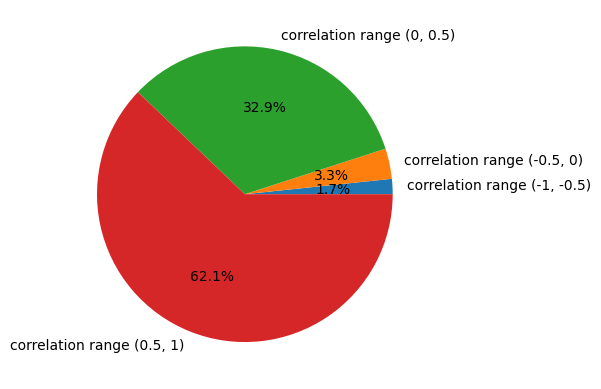

number of cells in the analysis:  602


In [7]:
# see how many cells are above/below the median

neg_corr_1_05 = get_cells_by_correlation_rate(scores_df_s3_s2, (-1, -0.5), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
neg_corr_05_0 = get_cells_by_correlation_rate(scores_df_s3_s2, (-0.5, 0), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
pos_corr_0_05 = get_cells_by_correlation_rate(scores_df_s3_s2, (0, 0.5), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
pos_corr_05_1 = get_cells_by_correlation_rate(scores_df_s3_s2, (0.5, 1), "score_motility", "score_intensity", rolling_w=6, time=(6,13))

array = [neg_corr_1_05["Spot track ID"].nunique(), neg_corr_05_0["Spot track ID"].nunique(), 
         pos_corr_0_05["Spot track ID"].nunique(), pos_corr_05_1["Spot track ID"].nunique()]
labels = ["correlation range (-1, -0.5)", "correlation range (-0.5, 0)", "correlation range (0, 0.5)", "correlation range (0.5, 1)"]
plt.pie(array, labels=labels, autopct='%1.1f%%')
plt.savefig(consts.storage_path + f"eps_figs/pie chart models agreement.eps", format="eps")
plt.show()

print("number of cells in the analysis: ", neg_corr_1_05["Spot track ID"].nunique() + neg_corr_05_0["Spot track ID"].nunique() +pos_corr_0_05["Spot track ID"].nunique() + pos_corr_05_1["Spot track ID"].nunique())

## global exploration

In [8]:
def plot_ecdfplot(data, y_val, color, label, modality):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.ecdfplot(data=data, y=y_val, color=color, complementary=True, label=label)
    med_val = data[y_val].quantile(.5)

    y_special = 0.5
    ax.text(med_val, med_val, f' {med_val:.2f}', ha='left', va='top')
    ax.axvline(0.5, linestyle='--', color='lightgray', lw=2, alpha=0.95)
    plt.ylim((-1,1))
    plt.ylabel("monotonicity rate")
    plt.title("monotonicty rate for cells both predictors highly agreed on (s2 + s3)")
    plt.savefig(consts.storage_path + f"eps_figs/monotonicty rate for cells both predictors (s2 + s3) {modality}.eps", format="eps")

corr range: (-1, -0.5)
number of cells in the analysis: 5
motility: normality test p-val=None, mean: 0.414, std: 0.798, median: 0.8, percentage >=0: 80.0 %
intensity: normality test p-val=None, mean: 0.0, std: 0.959, median: -0.2, percentage >=0: 40.0 %


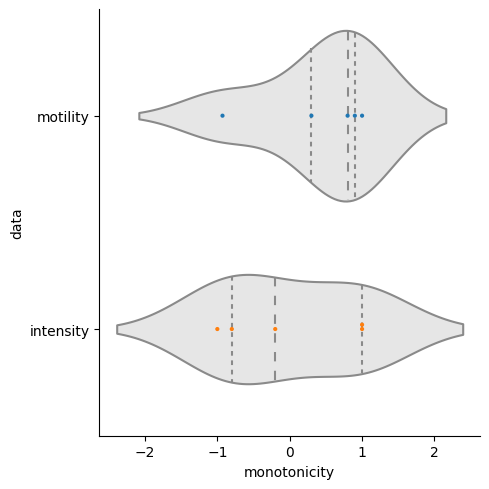

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


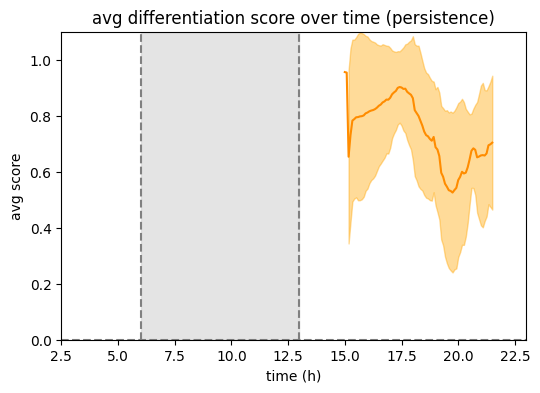

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

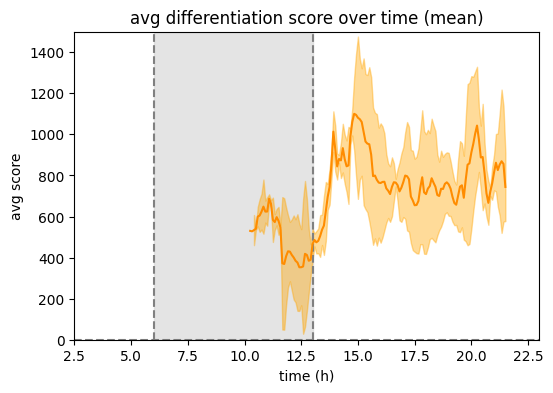

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

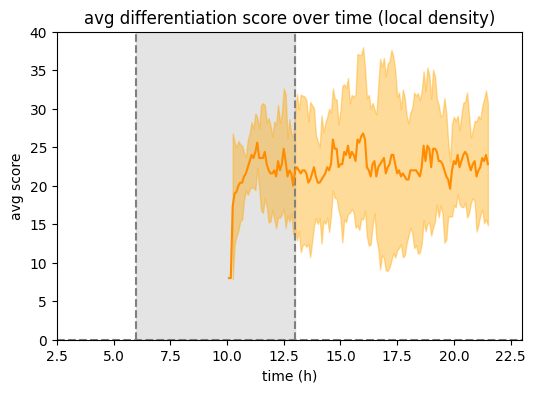

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

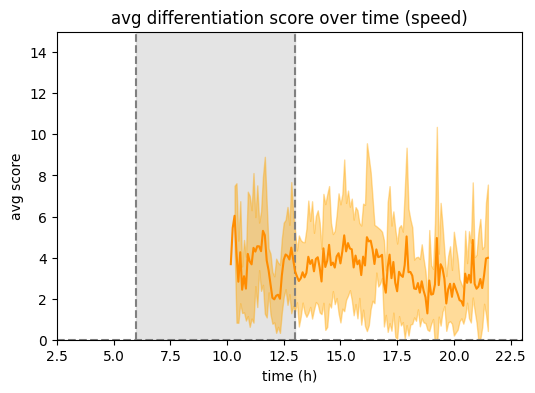

corr range: (-0.5, 0)
number of cells in the analysis: 18
motility: normality test p-val=0.4475454209005073, mean: 0.086, std: 0.61, median: 0.06, percentage >=0: 50.0 %
intensity: normality test p-val=0.06039616881793477, mean: 0.436, std: 0.465, median: 0.552, percentage >=0: 88.889 %


<Figure size 640x480 with 0 Axes>

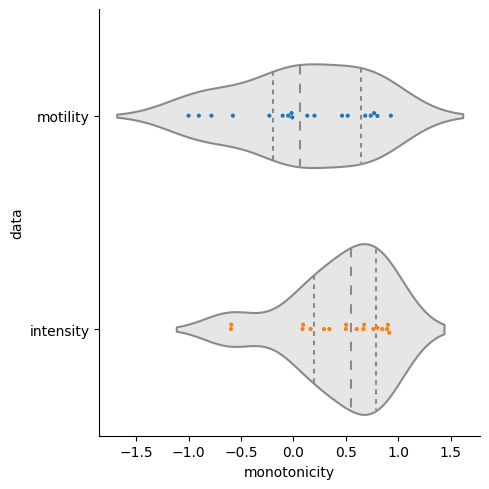

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


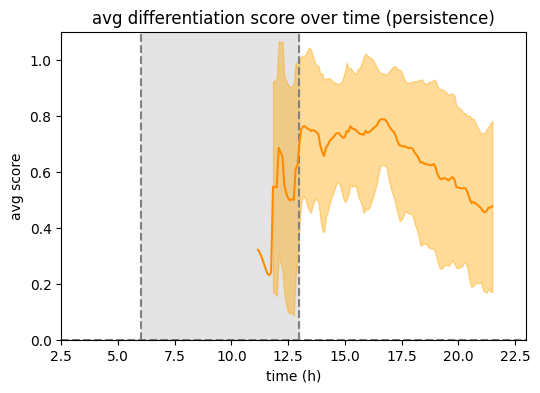

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

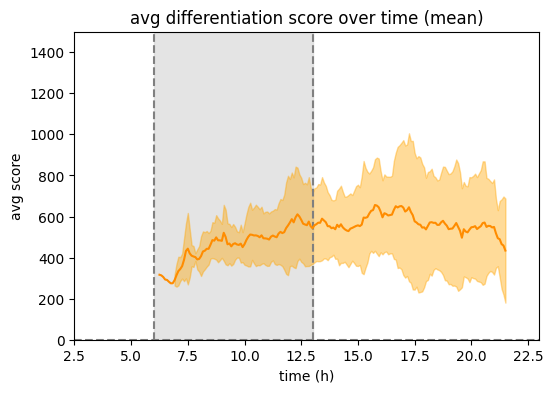

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

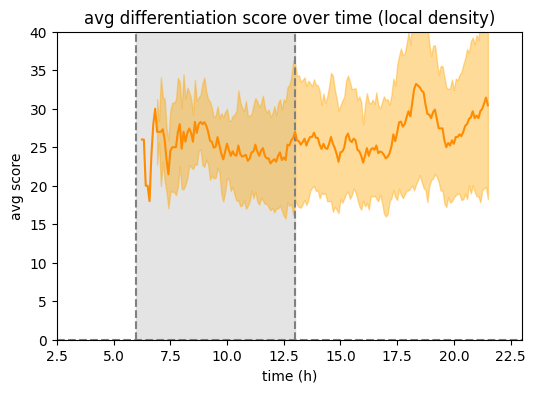

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

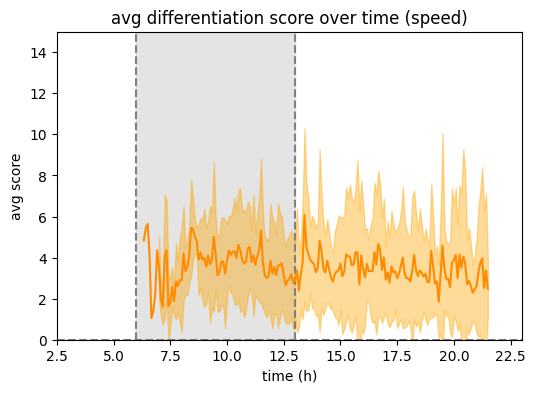

corr range: (0, 0.5)
number of cells in the analysis: 193
motility: normality test p-val=2.4730902276018113e-06, mean: 0.107, std: 0.527, median: 0.159, percentage >=0: 58.549 %
intensity: normality test p-val=1.6699940100022086e-06, mean: 0.399, std: 0.479, median: 0.525, percentage >=0: 81.865 %


<Figure size 640x480 with 0 Axes>

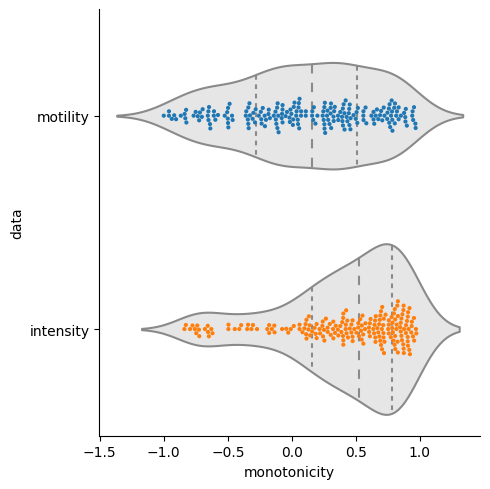

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


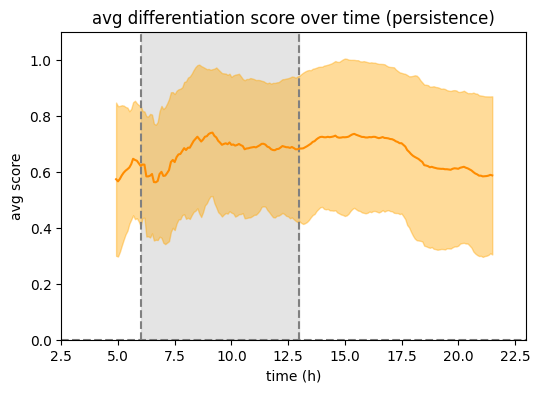

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

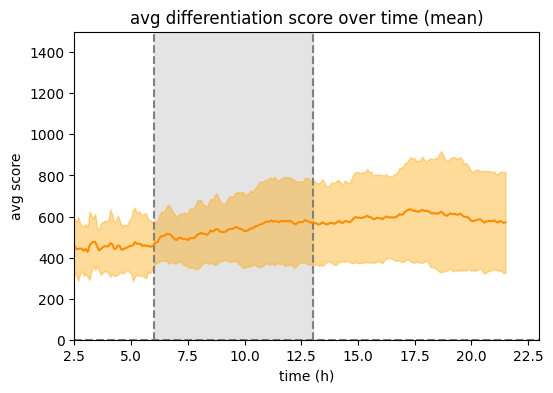

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

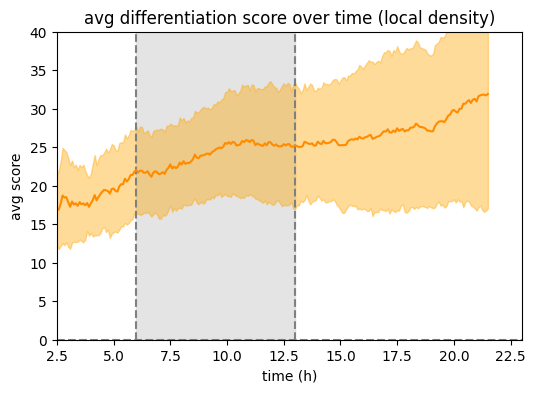

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

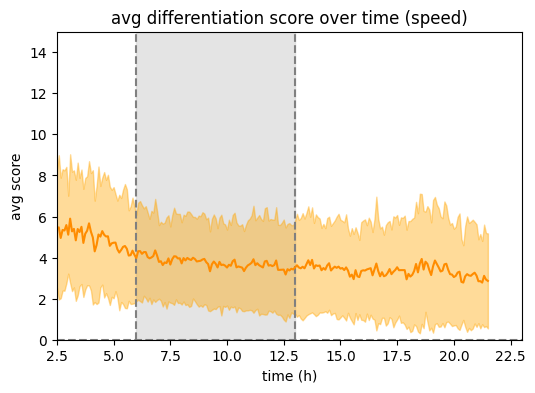

corr range: (0.5, 1)
number of cells in the analysis: 374
motility: normality test p-val=6.087208736593809e-14, mean: 0.494, std: 0.437, median: 0.655, percentage >=0: 85.561 %
intensity: normality test p-val=2.0678277870316896e-23, mean: 0.571, std: 0.399, median: 0.722, percentage >=0: 89.84 %


<Figure size 640x480 with 0 Axes>

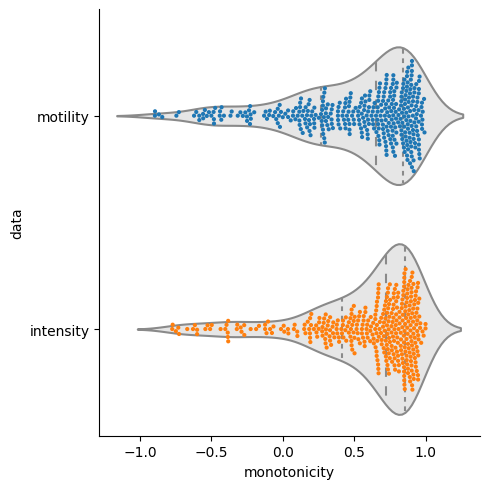

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


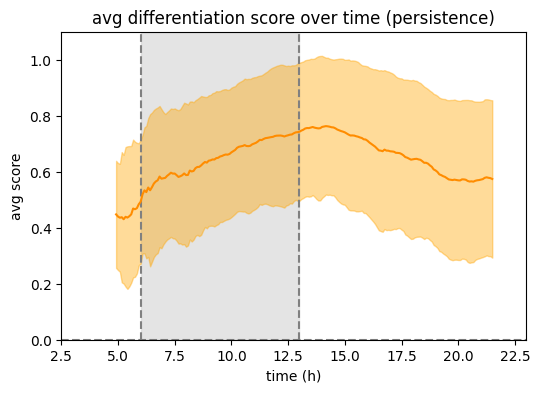

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

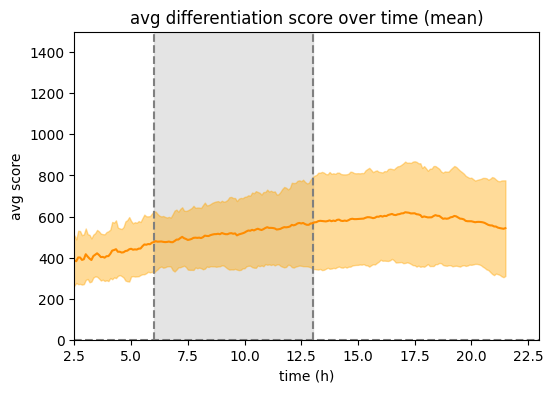

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

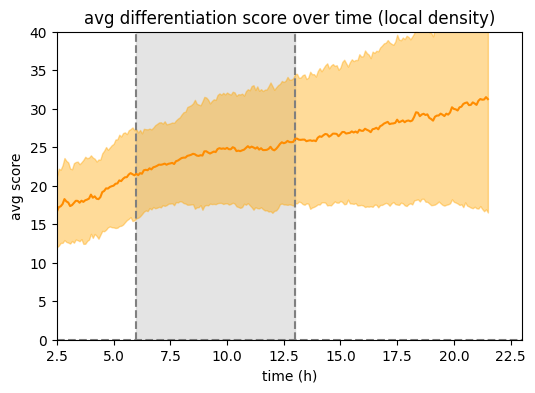

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

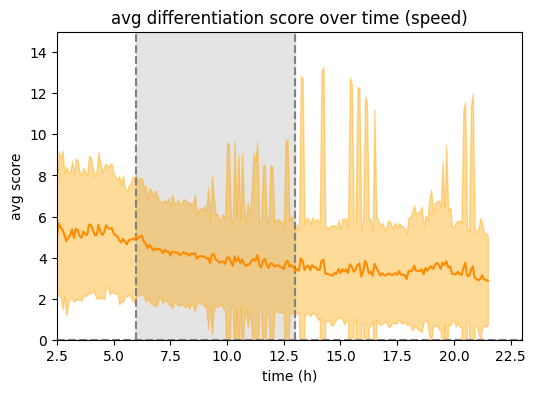

<Figure size 640x480 with 0 Axes>

In [22]:
def plot_by_corrlation_range(data, corr_range, mono_rolling=1, consent_rolling=6):
    constent_data = get_cells_by_correlation_rate(data, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))
    constent_data = calculator.get_monotonicity(constent_data, "motility", (6,13), rolling_w=mono_rolling)
    constent_data = calculator.get_monotonicity(constent_data, "intensity", (6,13), rolling_w=mono_rolling)

    fig_path = consts.storage_path + f"eps_figs/violin distribution monotonicity, corr_range {corr_range}.eps"
    utils.plot_violin_distributions(constent_data.drop_duplicates("Spot track ID"), "monotonicity", ["motility", "intensity"], plot_window=False, fig_path=fig_path)

    path = consts.storage_path + f"eps_figs/avg %s over time, corr_range {corr_range}"
    constent_data["score_persistence"] = constent_data["persistence"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "persistence", path=path % "persistence", plot_std=True, time=(6,13), xlim=(2.5, 23), ylim=(0, 1.1), axhline_val=0)
    
    constent_data["score_mean"] = constent_data["mean"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "mean", path=path % "mean", plot_std=True, time=(6,13), xlim=(2.5, 23), ylim=(0, 1500), axhline_val=0)
    
    constent_data["score_local density"] = constent_data["local density"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "local density", path=path % "local density", plot_std=True, time=(6,13), xlim=(2.5, 23), ylim=(0, 40), axhline_val=0)
    
    constent_data["score_speed"] = constent_data["speed"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "speed", path=path % "speed", plot_std=True, time=(6,13), xlim=(2.5, 23), ylim=(0, 15), axhline_val=0)

print(f"corr range: {(-1, -0.5)}")
plot_by_corrlation_range(scores_df_s3, (-1, -0.5), mono_rolling=1, consent_rolling=6)

print(f"corr range: {(-0.5, 0)}")
plot_by_corrlation_range(scores_df_s3, (-0.5, 0), mono_rolling=1, consent_rolling=6)

print(f"corr range: {(0, 0.5)}")
plot_by_corrlation_range(scores_df_s3, (0, 0.5), mono_rolling=1, consent_rolling=6)

print(f"corr range: {(0.5, 1)}")
plot_by_corrlation_range(scores_df_s3_s2, (0.5, 1), mono_rolling=1, consent_rolling=6)

## exploration in the single cell level

In [10]:
df_s3_fused = data_utils.get_scores_df_with_fusion()
scores_df_s3_fused = df_s3_fused.merge(scores_df_s3, how="left", on=["Spot track ID", "Spot frame", "time", "score_motility", "score_intensity", 'Spot position X', 'Spot position Y' ])

In [11]:
fused_high_constent_data = get_cells_by_correlation_rate(scores_df_s3_fused, (median_corr_s3_s2, 1), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
fused_low_constent_data = get_cells_by_correlation_rate(scores_df_s3_fused, (-0.2, 0.2), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
fused_no_constent_data = get_cells_by_correlation_rate(scores_df_s3_fused, (-1, -median_corr_s3_s2), "score_motility", "score_intensity", rolling_w=6, time=(6,13))

In [12]:
fused_high_constent_data["Spot track ID"].nunique(), fused_low_constent_data["Spot track ID"].nunique(), fused_no_constent_data["Spot track ID"].nunique()

(29, 10, 7)

In [13]:
def plot_analysis_by_ranges(data, track_id, ranges, range_by_feature):
    track = data[data["Spot track ID"] == track_id]
    corr = utils.get_correlation_coefficients(track, (6,13), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
    print(track_id)
    print("corr: ", round(corr[0], 3))

    for modality in ["motility", "intensity"]:
        utils.plot_diff_trajectories_single_cells([(track, "ERK")], modality, None , rolling_w=1, x_label="Spot frame")
    try:
        utils.plot_props_by_range(track, "time", ranges)
    except:
        pass
    print("====")

6993
corr:  0.372


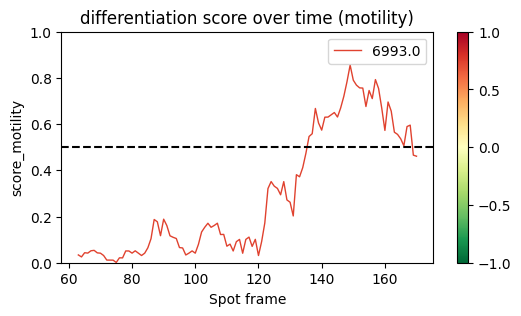

<Figure size 640x480 with 0 Axes>

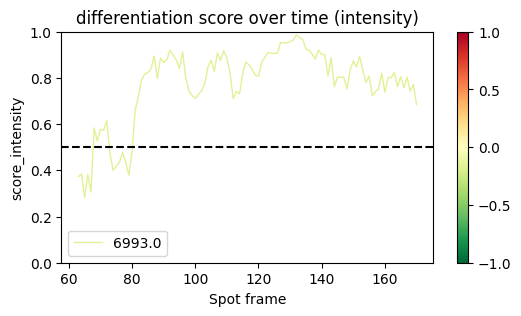

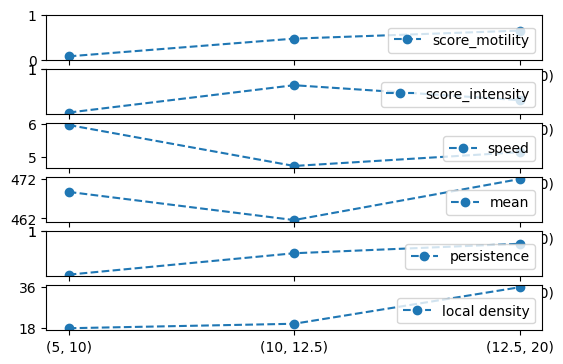

====


In [14]:
plot_analysis_by_ranges(scores_df_s3_fused, 6993, [(5, 10), (10, 12.5), (12.5, 20)], "time")

In [15]:
low_corr_ids = [8662, 20857, 3637]
neg_corr_ids = [6449, 5453, 7127] 

8662
corr:  -0.158


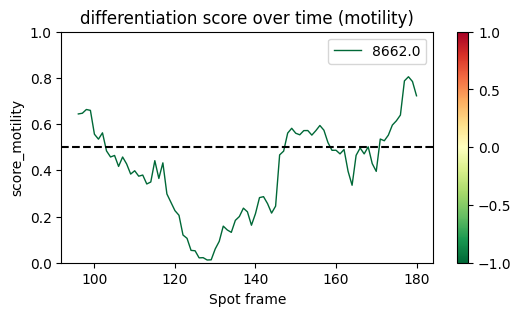

<Figure size 640x480 with 0 Axes>

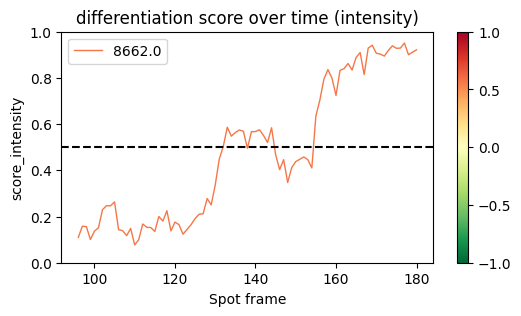

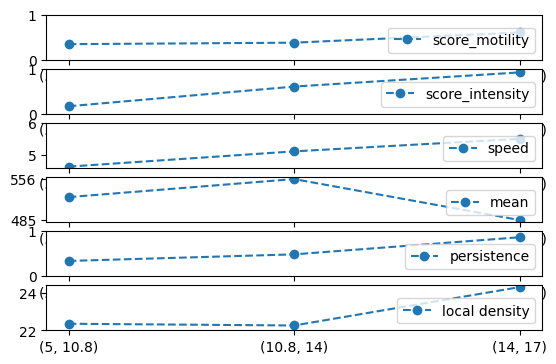

====


In [16]:
plot_analysis_by_ranges(scores_df_s3_fused, 8662, [(5, 10.8), (10.8, 14), (14, 17)], "time")

20857
corr:  -0.052


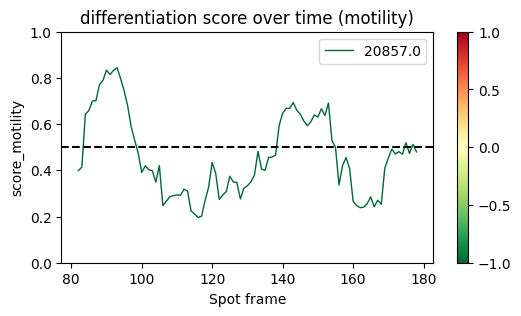

<Figure size 640x480 with 0 Axes>

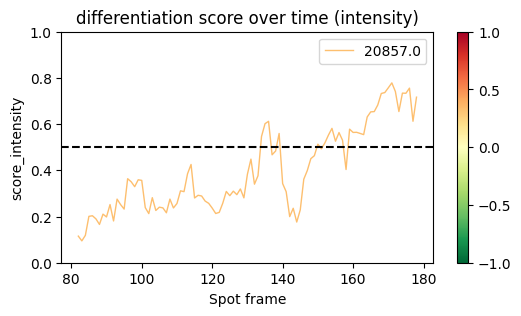

====


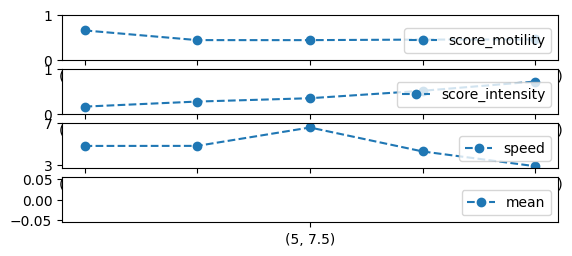

In [17]:
plot_analysis_by_ranges(scores_df_s3_fused, 20857, [(5, 7.5), (7.5, 10), (10, 12), (12, 14), (14, 24)], "time")

3637
corr:  0.107


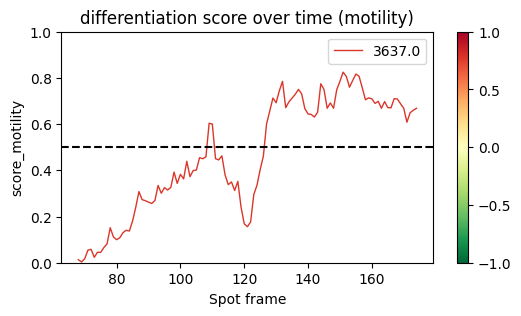

<Figure size 640x480 with 0 Axes>

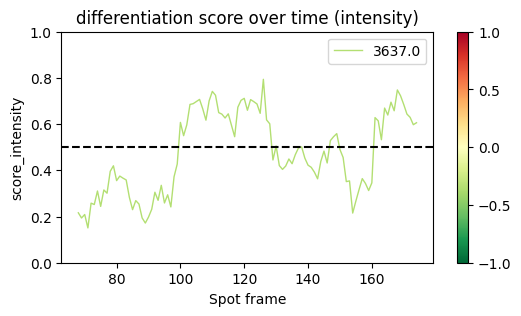

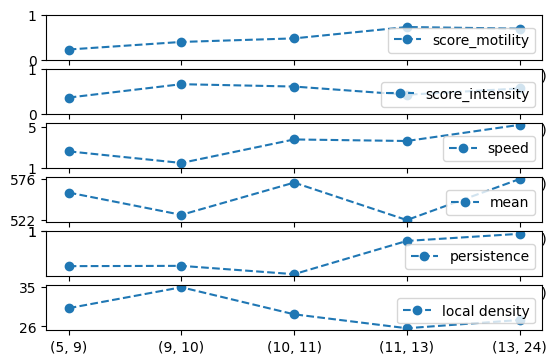

====


In [18]:
plot_analysis_by_ranges(scores_df_s3_fused, 3637, [(5, 9), (9, 10), (10, 11), (11, 13), (13, 24)], "time")

6449
corr:  -0.623


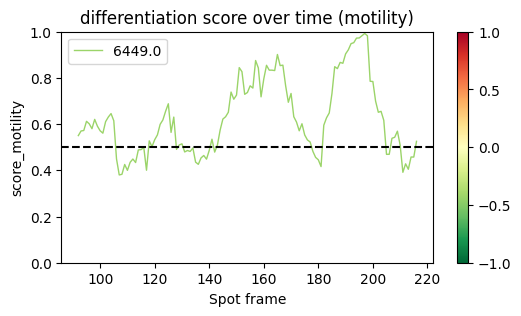

<Figure size 640x480 with 0 Axes>

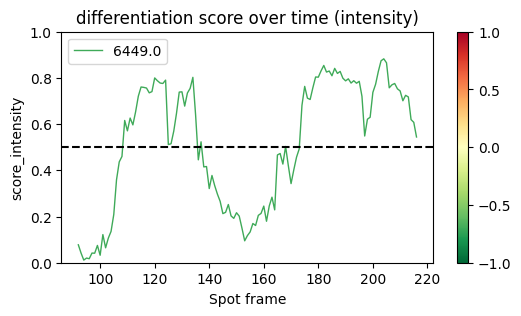

====


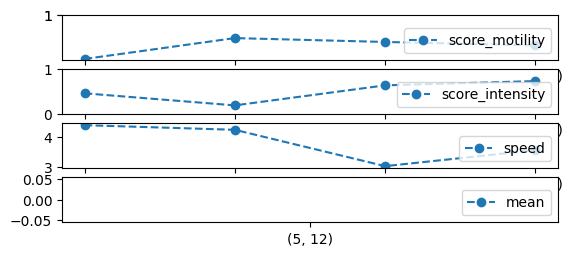

In [19]:
plot_analysis_by_ranges(scores_df_s3_fused, 6449, [(5, 12), (12, 13.5), (13.5, 16), (16, 24)], "time")

5453
corr:  -0.912


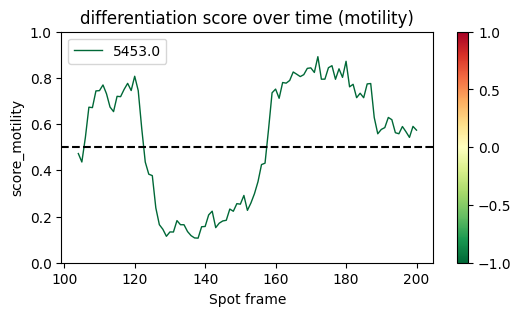

<Figure size 640x480 with 0 Axes>

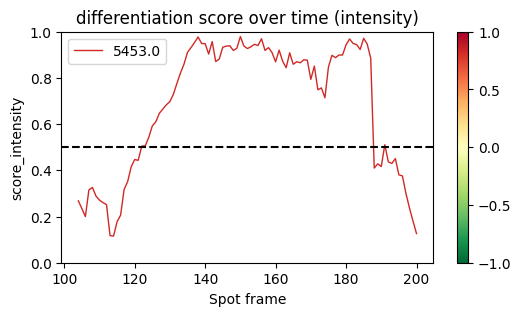

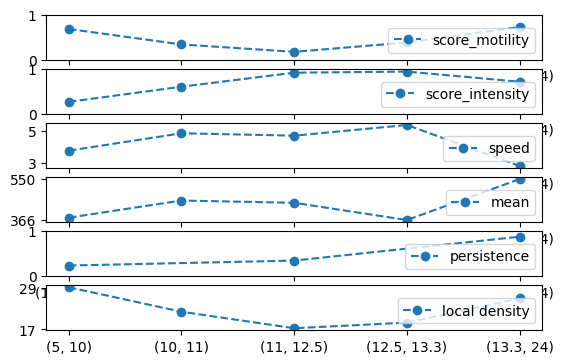

====


In [20]:
plot_analysis_by_ranges(scores_df_s3_fused, 5453, [(5, 10), (10, 11), (11, 12.5), (12.5, 13.3), (13.3, 24)], "time")

7127
corr:  -0.906


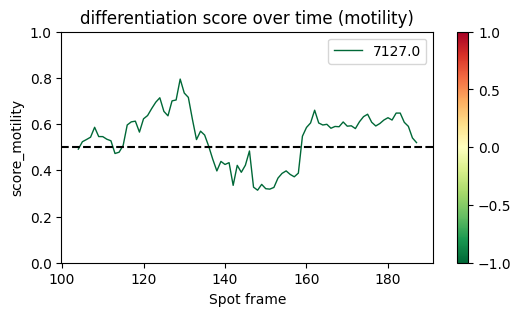

<Figure size 640x480 with 0 Axes>

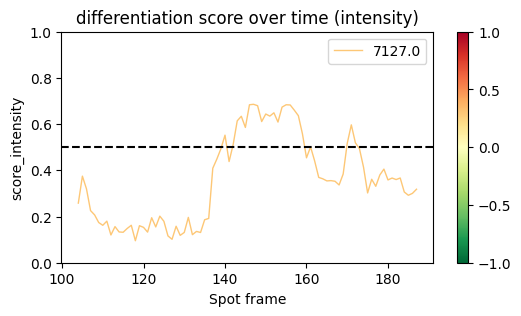

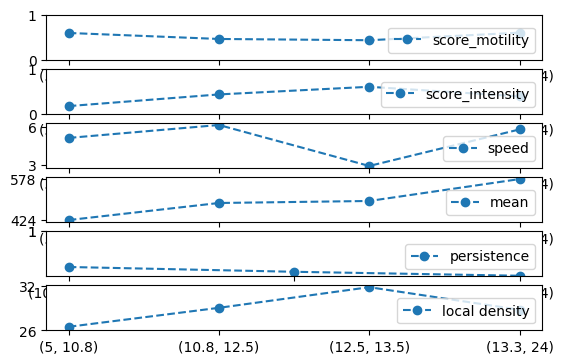

====


In [21]:
plot_analysis_by_ranges(scores_df_s3_fused, 7127, [(5, 10.8), (10.8, 12.5), (12.5, 13.5), (13.3, 24)], "time")